# Chapter 17 - Metric Predicted Variable with One Metric Predictor

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import scipy as spy

import matplotlib.pyplot as plt

from matplotlib import gridspec
from IPython.display import Image

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use('seaborn-v0_8-white')

color = '#87ceeb'

f_dict = {'size':16}

In [3]:
%load_ext watermark
%watermark -p matplotlib,numpy,pandas,pymc,seaborn,scipy

matplotlib: 3.10.0
numpy     : 1.26.4
pandas    : 2.2.3
pymc      : 5.16.1
seaborn   : 0.13.2
scipy     : 1.12.0



In [4]:
def plot_grid(idata, data, sd_h, sd_w, mean_h, mean_w):
    """This function creates plots like figures 17.3 and 17.4 in the book."""

    fig = plt.figure(figsize=(13, 13))

    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[:2, 1:5])
    ax2 = plt.subplot(gs[2, :2])
    ax3 = plt.subplot(gs[2, 2:4])
    ax4 = plt.subplot(gs[2, 4:6])
    ax5 = plt.subplot(gs[3, :2])
    ax6 = plt.subplot(gs[3, 2:4])
    ax7 = plt.subplot(gs[3, 4:6])

    # Scatter plot of the observed data
    ax1.scatter(
        data.height,
        data.weight,
        s=40,
        linewidths=1,
        facecolor="none",
        edgecolor="k",
        zorder=10,
    )
    ax1.set_xlabel("height", fontdict=f_dict)
    ax1.set_ylabel("weight", fontdict=f_dict)
    ax1.set(xlim=(0, 80), ylim=(-350, 250))

    # Convert parameters to original scale
    beta0 = (
        idata.posterior["beta0"] * sd_w
        + mean_w
        - idata.posterior["beta1"] * mean_h * sd_w / sd_h
    )
    beta1 = idata.posterior["beta1"] * (sd_w / sd_h)
    sigma = idata.posterior["sigma"] * sd_w
    B = pd.DataFrame({"beta0": beta0.values.flatten(), "beta1": beta1.values.flatten()})

    # credible regression lines from posterior
    b0_hdi = np.round(az.hdi(B["beta0"].to_numpy(), hdi_prob=0.95))
    b1_hdi = np.round(az.hdi(B["beta1"].to_numpy(), hdi_prob=0.95))
    B_hdi = B[
        B["beta0"].between(*b0_hdi) & B["beta1"].between(*b1_hdi)
    ]
    xrange = np.arange(0, data.height.max() * 1.05)
    for i in np.random.randint(0, len(B_hdi), 30):
        ax1.plot(
            xrange,
            B_hdi.iloc[i, 0] + B_hdi.iloc[i, 1] * xrange,
            c=color,
            alpha=0.6,
            zorder=0,
        )

    # intercept
    pm.plot_posterior(beta0, point_estimate="mode", ax=ax2, color=color)
    ax2.set_xlabel(r"$\beta_0$", fontdict=f_dict)
    ax2.set_title("Intercept", fontdict={"weight": "bold"})

    # slope
    pm.plot_posterior(beta1, point_estimate="mode", ax=ax3, color=color, ref_val=0)
    ax3.set_xlabel(r"$\beta_1$", fontdict=f_dict)
    ax3.set_title("Slope", fontdict={"weight": "bold"})

    # scatter plot beta1, beta0
    ax4.scatter(beta1, beta0, edgecolor=color, facecolor="none", alpha=0.6)
    ax4.set_xlabel(r"$\beta_1$", fontdict=f_dict)
    ax4.set_ylabel(r"$\beta_0$", fontdict=f_dict)

    # scale
    pm.plot_posterior(sigma, point_estimate="mode", ax=ax5, color=color)
    ax5.set_xlabel(r"$\sigma$", fontdict=f_dict)
    ax5.set_title("Scale", fontdict={"weight": "bold"})

    # normality
    pm.plot_posterior(
        np.log10(idata.posterior["nu"]), point_estimate="mode", ax=ax6, color=color
    )
    ax6.set_xlabel(r"log10($\nu$)", fontdict=f_dict)
    ax6.set_title("Normality", fontdict={"weight": "bold"})

    # scatter plot normality, sigma
    ax7.scatter(
        np.log10(idata.posterior["nu"]),
        sigma,
        edgecolor=color,
        facecolor="none",
        alpha=0.6,
    )
    ax7.set_xlabel(r"log10($\nu$)", fontdict=f_dict)
    ax7.set_ylabel(r"$\sigma$", fontdict=f_dict)

    plt.tight_layout()

    return fig

In [5]:
def plot_cred_lines(beta0, beta1, x, sd_x, sd_y, mean_x, mean_y, ax):
    """This function plots credibility lines."""
    # Convert parameters to original scale
    beta0 = beta0 * sd_y + mean_y - beta1 * mean_x * sd_y / sd_x
    beta1 = beta1 * (sd_y / sd_x)
    B = pd.DataFrame({"beta0": beta0.values.flatten(), "beta1": beta1.values.flatten()})

    # Credible regression lines from posterior
    beta0_hdi = az.hdi(B["beta0"].to_numpy(), hdi_prob=0.95)
    beta1_hdi = az.hdi(B["beta1"].to_numpy(), hdi_prob=0.95)
    B_hdi = B[
        B["beta0"].between(*beta0_hdi) & B["beta1"].between(*beta1_hdi)
    ]
    #print([beta0_hdi, beta1_hdi, len(B_hdi)])
    xrange = np.arange(x.min() * 0.95, x.max() * 1.05)
    for i in np.random.randint(0, len(B_hdi), 30):
        ax.plot(
            xrange,
            B_hdi.iloc[i, 0] + B_hdi.iloc[i, 1] * xrange,
            c=color,
            alpha=0.6,
            zorder=0,
        )

In [6]:
def plot_quad_credlines(beta0, beta1, beta2, x, sd_x, sd_y, mean_x, mean_y, ax):
    """This function plots quadratic credibility lines."""
    # Convert parameters to original scale
    beta0 = (
        beta0 * sd_y
        + mean_y
        - beta1 * mean_x * sd_y / sd_x
        + beta2 * mean_x**2 * sd_y / sd_x**2
    )
    beta1 = beta1 * sd_y / sd_x - 2 * beta2 * mean_x * sd_y / sd_x**2
    beta2 = beta2 * sd_y / sd_x**2
    B = pd.DataFrame(
        {
            "beta0": beta0.values.flatten(),
            "beta1": beta1.values.flatten(),
            "beta2": beta2.values.flatten(),
        }
    )

    # credible regression lines from posterior
    beta0_hdi = az.hdi(B["beta0"].to_numpy(), hdi_prob=0.95)
    beta1_hdi = az.hdi(B["beta1"].to_numpy(), hdi_prob=0.95)
    beta2_hdi = az.hdi(B["beta2"].to_numpy(), hdi_prob=0.95)
    B_hdi = B[
        B["beta0"].between(*beta0_hdi)
        & B["beta1"].between(*beta1_hdi)
        & B["beta2"].between(*beta2_hdi)
    ]
    xrange = np.arange(x.min() - 1, x.max() + 2)
    for i in np.random.randint(0, len(B_hdi), 30):
        ax.plot(
            xrange,
            B_hdi.iloc[i, 0]
            + B_hdi.iloc[i, 1] * xrange
            + B_hdi.iloc[i, 2] * xrange**2,
            c=color,
            alpha=0.6,
            zorder=0,
        )

## 17.2 - Robust Linear Regression

### N = 30

In [7]:
df_n30 = pd.read_csv(
    'C:/Users/bacos1/Documents/Python/per_python_bayes/Doing_Bayesian_Data_Analysis/data/HtWtData30.csv',
)

df_n30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    30 non-null     int64  
 1   height  30 non-null     float64
 2   weight  30 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 852.0 bytes


In [10]:
df_n30.head()

male  height  weight
0     0    64.0   136.4
1     0    62.3   215.1
2     1    67.9   173.6
3     0    64.2   117.3
4     0    64.8   123.3

In [8]:
df_n30_std = (df_n30
              .assign(
                  zheight = lambda x: spy.stats.zscore(x['height']),
                  zweight = lambda x: spy.stats.zscore(x['weight'])
              )
              )

In [9]:
with pm.Model() as model:
    # Priors
    beta0 = pm.Normal('beta0', mu = 0, tau = 1 / 10**2)
    beta1 = pm.Normal('beta1', mu = 0, tau = 1 / 10**2)
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    nu = pm.Exponential("nu", 1 / 29.0)

    # Model    
    mu = beta0 + beta1 * df_n30_std['zheight']

    # Likelihood

    likelihood = pm.StudentT(
        'likelihood',
        nu,
        mu = mu,
        sigma = sigma,
        observed = df_n30_std['zweight']
    )    

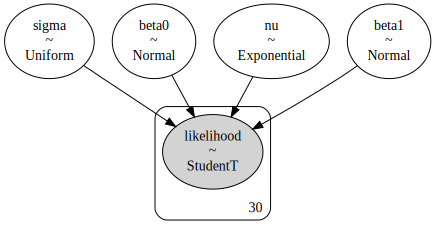

In [21]:
pm.model_to_graphviz(model)

In [10]:
with model:
    idata = pm.sample(5000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 55 seconds.


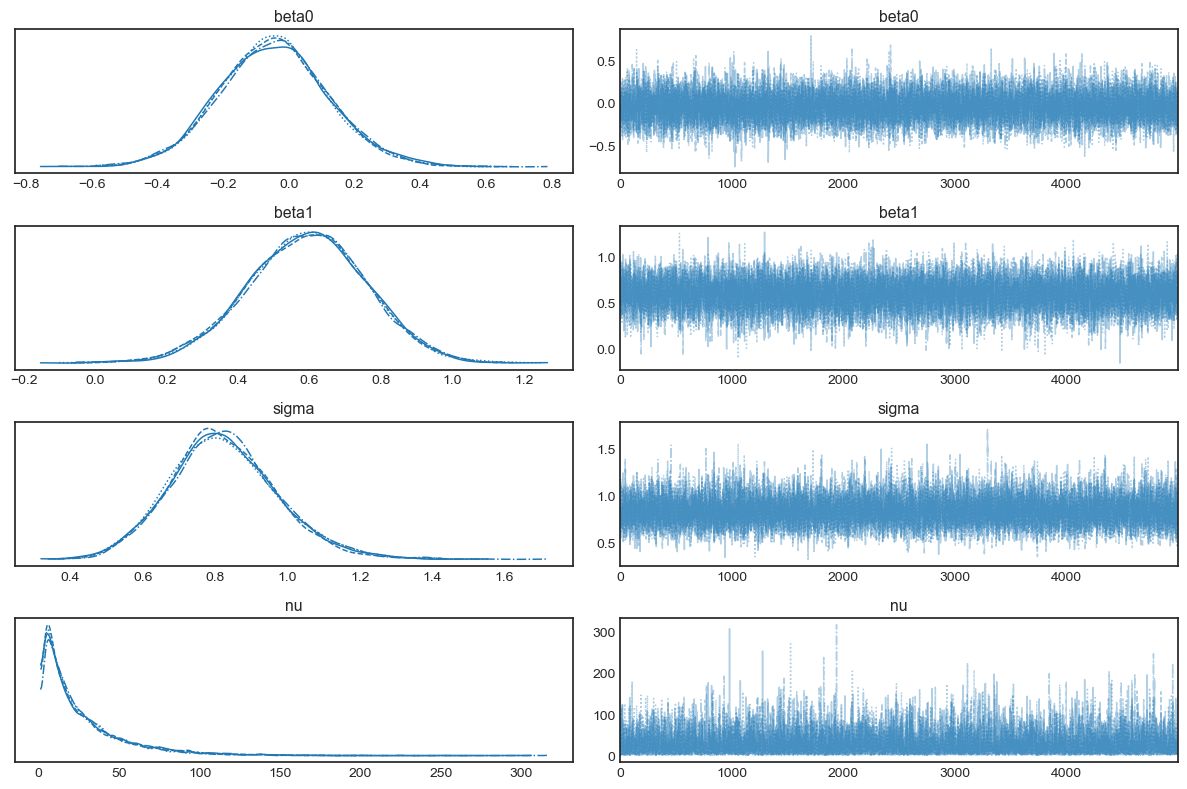

In [11]:
az.plot_trace(idata)
plt.tight_layout();

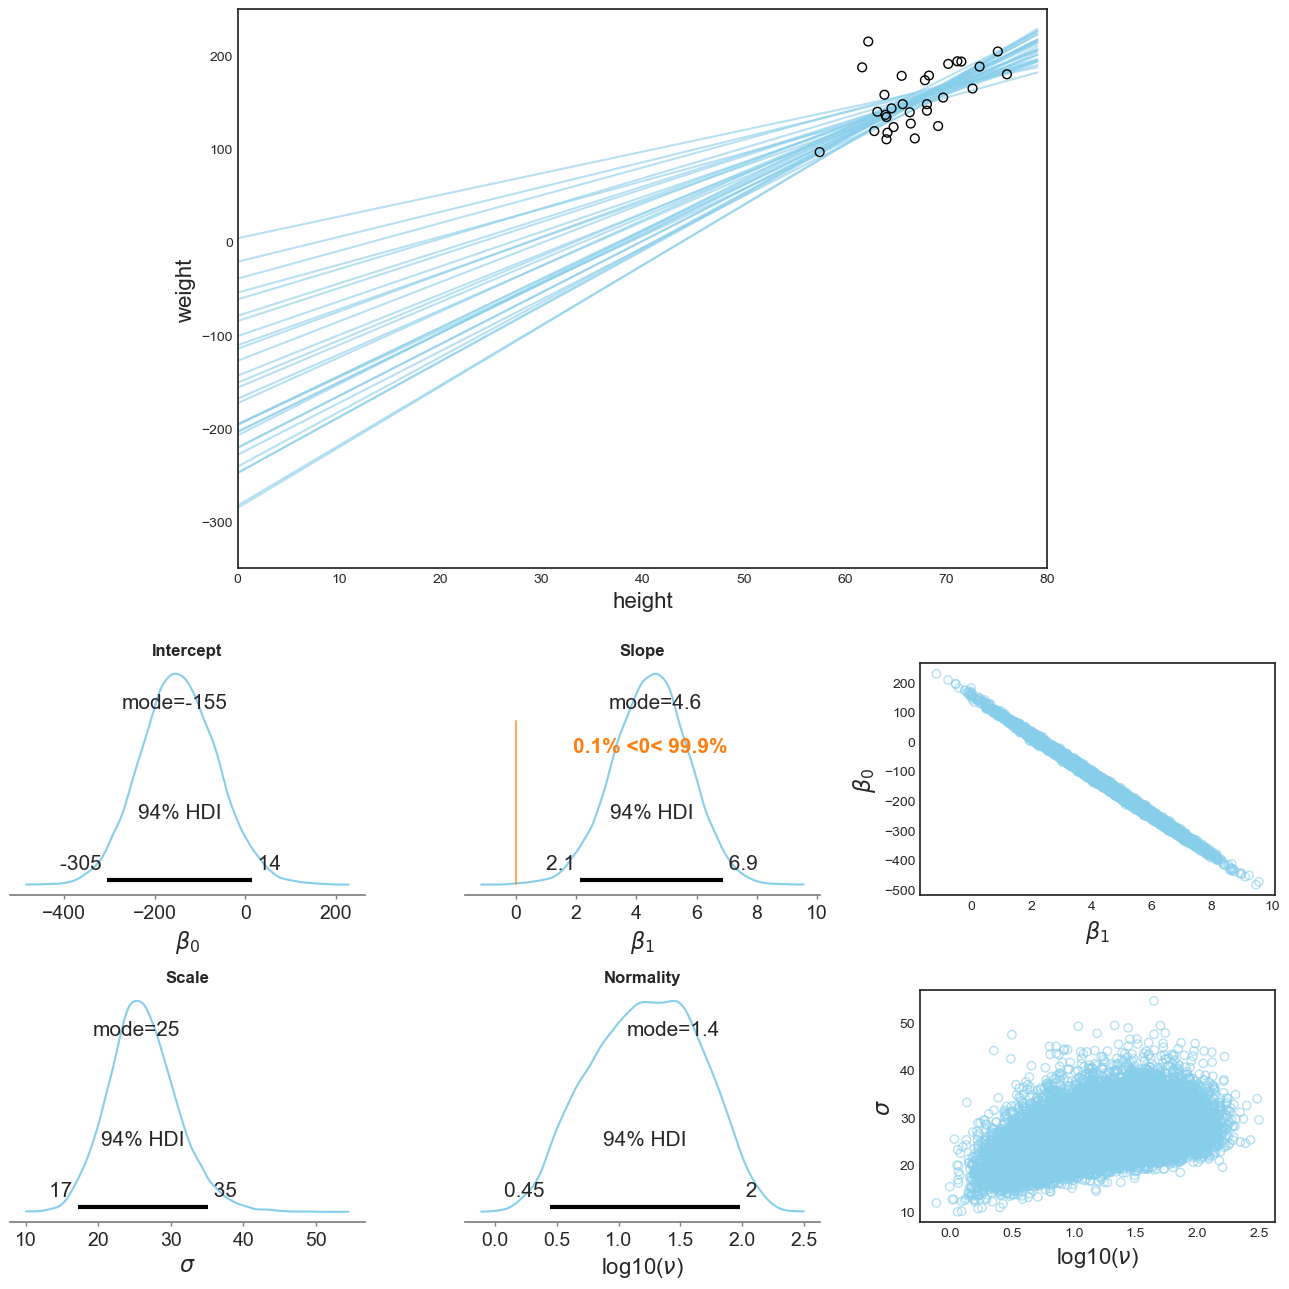

In [12]:
plot_grid(
    idata,
    df_n30,
    df_n30["height"].std(),
    df_n30["weight"].std(),
    df_n30["height"].mean(),
    df_n30["weight"].mean(),
);

### N = 300

In [13]:
df_n300 = pd.read_csv(
    'C:/Users/bacos1/Documents/Python/per_python_bayes/Doing_Bayesian_Data_Analysis/data/HtWtData300.csv',
)

df_n300.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    300 non-null    int64  
 1   height  300 non-null    float64
 2   weight  300 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.2 KB


In [14]:
df_n300_std = (df_n300
              .assign(
                  zheight = lambda x: spy.stats.zscore(x['height']),
                  zweight = lambda x: spy.stats.zscore(x['weight'])
              )
              )

In [15]:
with pm.Model() as model2:
    # Priors
    beta0 = pm.Normal('beta0', mu = 0, tau = 1 / 10**2)
    beta1 = pm.Normal('beta1', mu = 0, tau = 1 / 10**2)
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    nu = pm.Exponential("nu", 1 / 29.0)

    # Model    
    mu = beta0 + beta1 * df_n300_std['zheight']

    # Likelihood

    likelihood = pm.StudentT(
        'likelihood',
        nu,
        mu = mu,
        sigma = sigma,
        observed = df_n300_std['zweight']
    )    

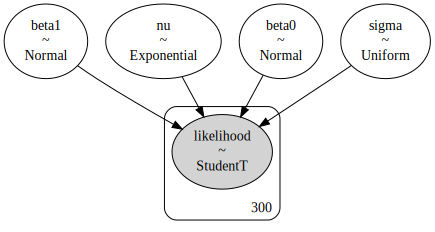

In [16]:
pm.model_to_graphviz(model2)

In [17]:
with model2:
    idata2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 44 seconds.


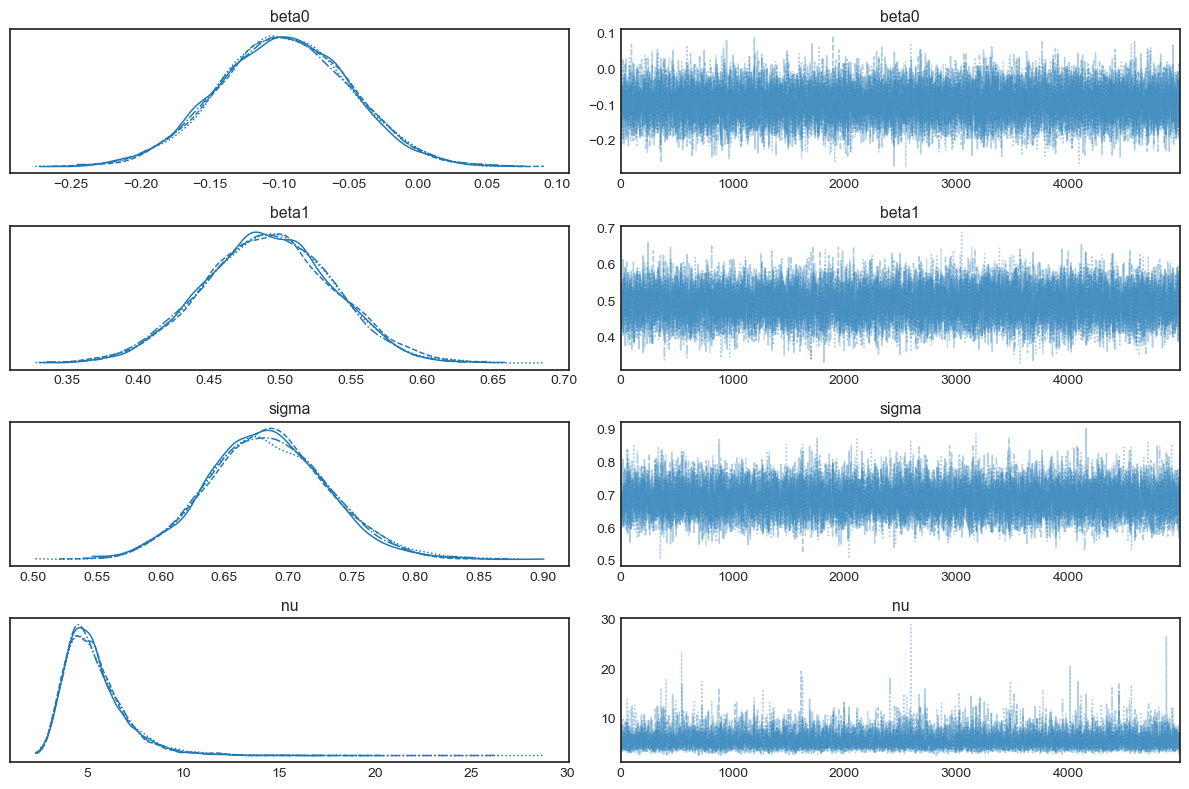

In [18]:
az.plot_trace(idata2)
plt.tight_layout();

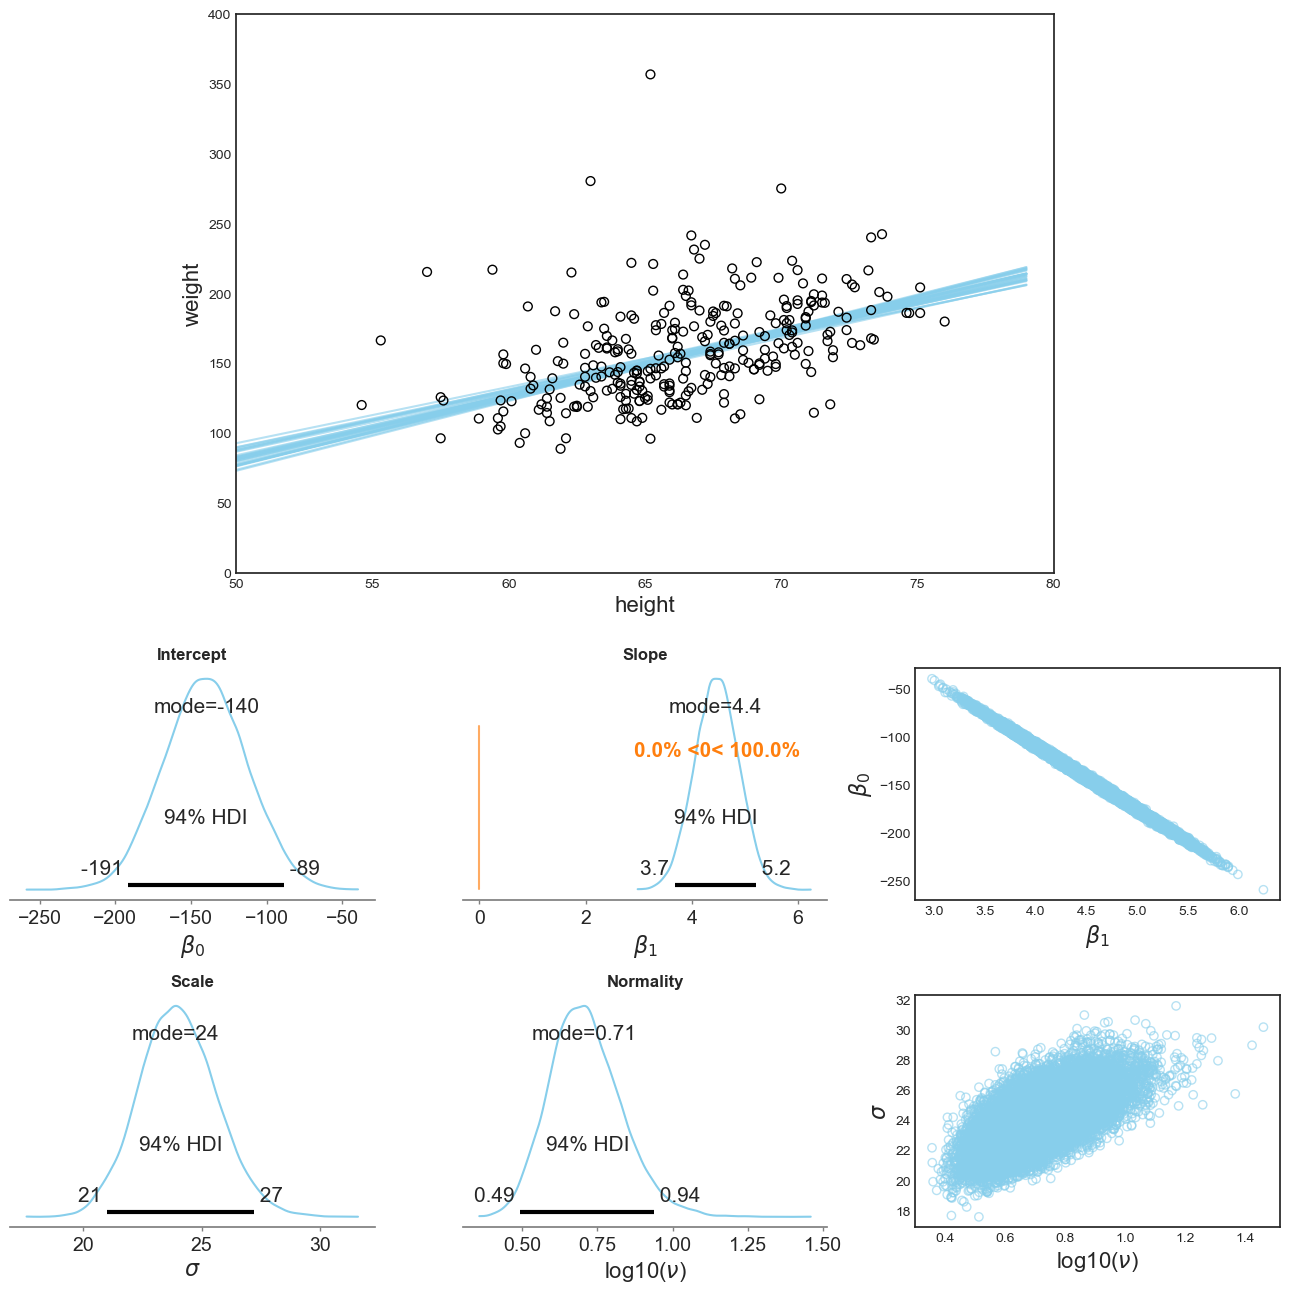

In [19]:
grid = plot_grid(
    idata2,
    df_n300,
    df_n300["height"].std(),
    df_n300["weight"].std(),
    df_n300["height"].mean(),
    df_n300["weight"].mean(),
)
grid.axes[0].set_xlim(50, 80)
grid.axes[0].set_ylim(0, 400);

## 17.3 - Hierarchical Regression on Individuals within Groups

In [20]:
df_HRegr = pd.read_csv('C:/Users/bacos1/Documents/Python/per_python_bayes/Doing_Bayesian_Data_Analysis/data/HierLinRegressData.csv')

In [33]:
df_HRegr.head(10)

Subj     X      Y
0     1  60.2  145.6
1     1  61.5  157.3
2     1  61.7  165.6
3     1  62.3  158.8
4     1  67.6  196.1
5     1  69.2  183.9
6     2  53.7  165.0
7     2  60.1  166.9
8     2  60.5  179.0
9     2  62.3  196.2

In [21]:
# Create index

subj_idx, subj_codes = pd.factorize(df_HRegr['Subj'])
n_subj = df_HRegr['Subj'].nunique()

In [22]:
df_HRegr_std = (df_HRegr
              .assign(
                  zx3 = lambda x: spy.stats.zscore(x['X']),
                  zy3 = lambda x: spy.stats.zscore(x['Y'])
              )
              )

In [23]:
with pm.Model() as model3:
    # Priors
    beta0 = pm.Normal("beta0", mu=0, tau=1 / 10**2)
    beta1 = pm.Normal("beta1", mu=0, tau=1 / 10**2)
    sigma0 = pm.Uniform("sigma0", 10**-3, 10**3)
    sigma1 = pm.Uniform("sigma1", 10**-3, 10**3)
    sigma = pm.Uniform("sigma", 10**-3, 10**3)
    nu = pm.Exponential("nu", 1 / 29.0)

    # Offset specification
    beta0_s_offset = pm.Normal('beta0_s_offset', mu = 0, sigma = 1, shape = n_subj)
    beta0_s = pm.Normal('beta0_s', beta0 + beta0_s_offset * sigma0)
    beta1_s_offset = pm.Normal("beta1_s_offset", mu=0, sigma=1, shape=n_subj)
    beta1_s = pm.Deterministic("beta1_s", beta1 + beta1_s_offset * sigma1)

    # Model
    mu = beta0_s[subj_idx] + beta1_s[subj_idx] * df_HRegr_std['zx3']

    # Likelihood

    likelihood = pm.StudentT(
        'likelihood',
        nu, 
        mu,
        sigma = sigma,
        observed = df_HRegr_std['zy3']
    )

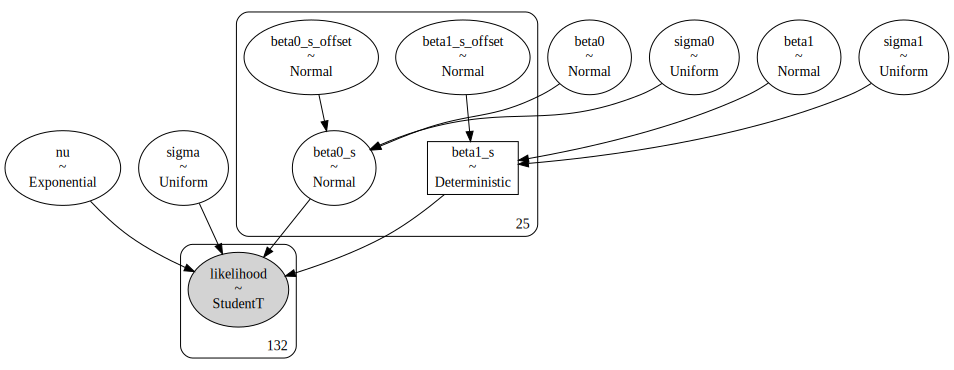

In [24]:
pm.model_to_graphviz(model3)

In [25]:
with model3:
    idata3 = pm.sample(5000, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma0, sigma1, sigma, nu, beta0_s_offset, beta0_s, beta1_s_offset]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 368 seconds.


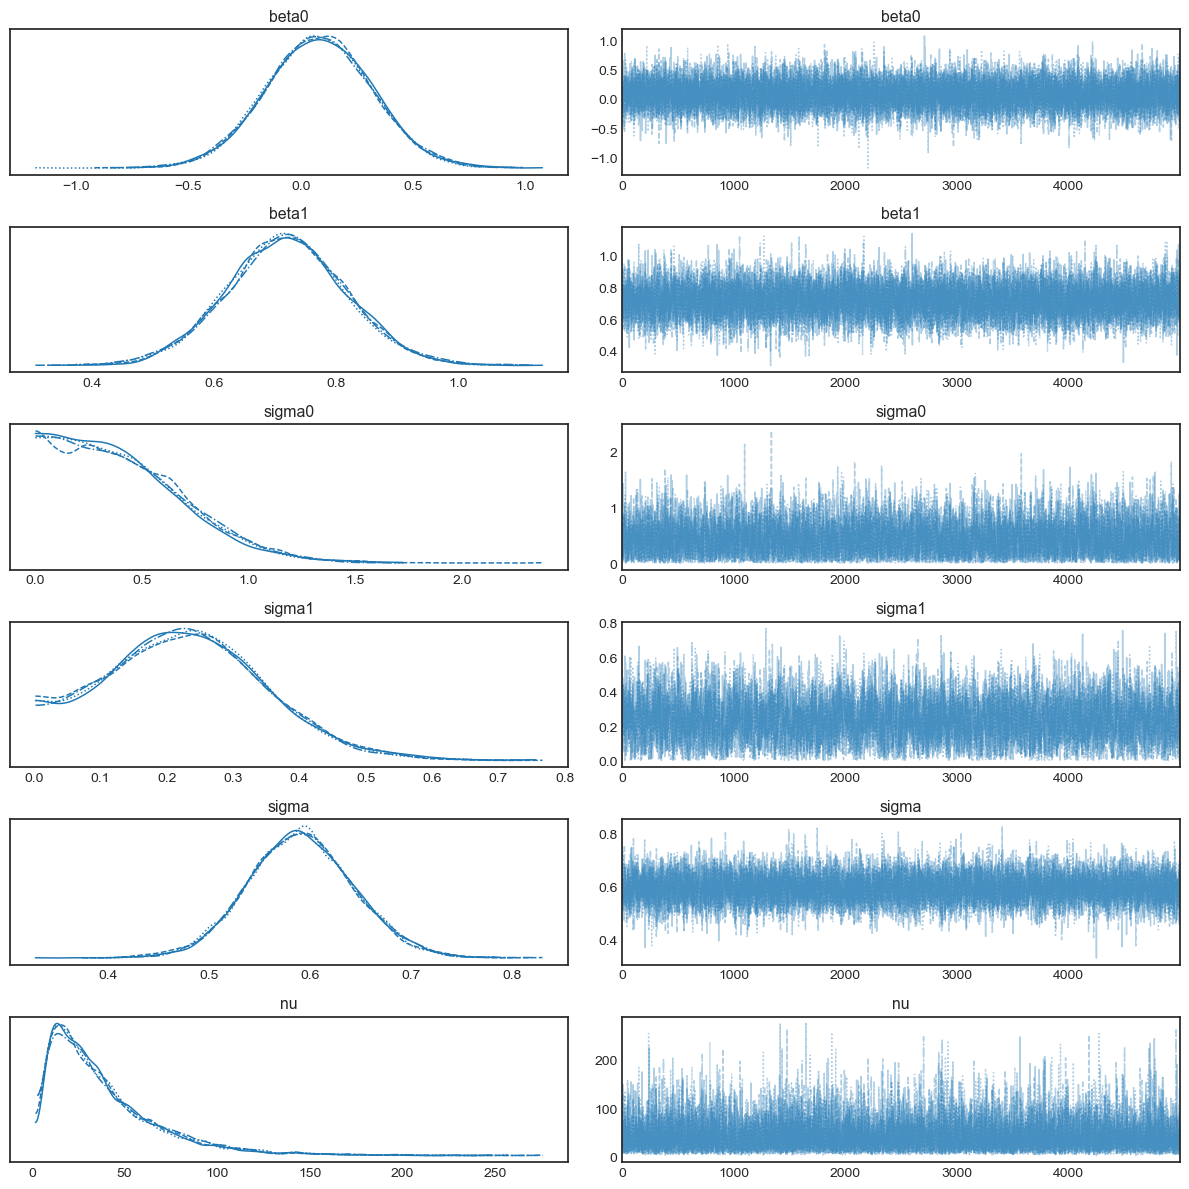

In [26]:
az.plot_trace(idata3, var_names=["beta0", "beta1", "sigma0", "sigma1", "sigma", "nu"])
plt.tight_layout();

C:\Users\bacos1\AppData\Local\Temp\ipykernel_19496\2767358161.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_HRegr.groupby("Subj").apply(


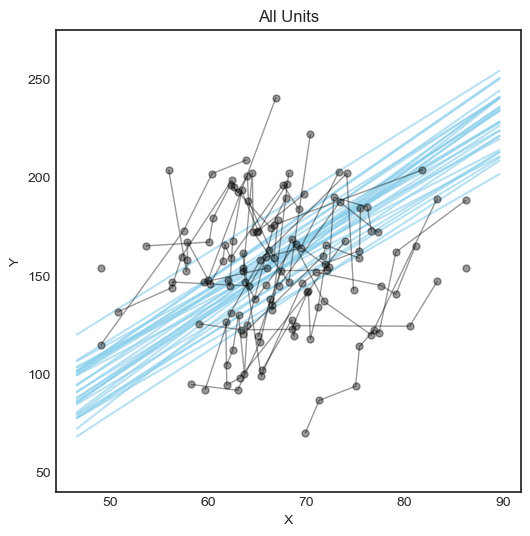

In [27]:
plt.figure(figsize=(6, 6))
ax = plt.gca()

df_HRegr.groupby("Subj").apply(
    lambda group: ax.plot(group.X, group.Y, "k-o", lw=1, markersize=5, alpha=0.4)
)
ax.set(xlabel="X", ylabel="Y", ylim=(40, 275), title="All Units")

plot_cred_lines(
    idata3.posterior["beta0"],
    idata3.posterior["beta1"],
    df_HRegr["X"],
    df_HRegr["X"].std(),
    df_HRegr["Y"].std(),
    df_HRegr["X"].mean(),
    df_HRegr["Y"].mean(),
    ax,
)

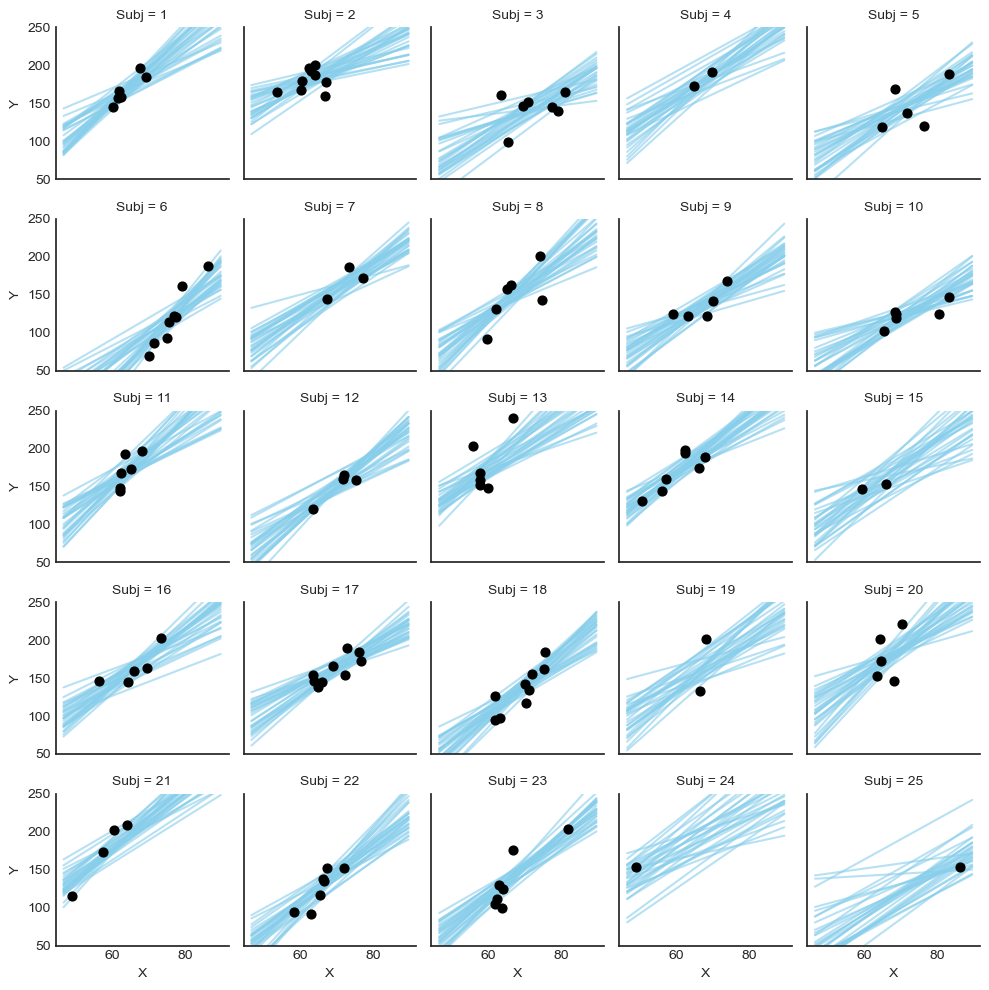

In [28]:
fg = sns.FacetGrid(df_HRegr, col="Subj", col_wrap=5, ylim=(50, 250), height=2)
fg.map(plt.scatter, "X", "Y", color="k", s=40)

for i, ax in enumerate(fg.axes):
    plot_cred_lines(
        idata3.posterior["beta0_s"].sel(beta0_s_dim_0=i),
        idata3.posterior["beta1_s"].sel(beta1_s_dim_0=i),
        df_HRegr["X"],
        df_HRegr["X"].std(),
        df_HRegr["Y"].std(),
        df_HRegr["X"].mean(),
        df_HRegr["Y"].mean(),
        ax,
    )

# 17.4 - Quadratic Trend and Weighted Data

In [29]:
df_income = pd.read_csv(
    'C:/Users/bacos1/Documents/Python/per_python_bayes/Doing_Bayesian_Data_Analysis/data/IncomeFamszState3yr.csv',
    skiprows = 1,
    dtype = {'State':'category'}
)

df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   FamilySize    312 non-null    int64   
 1   State         312 non-null    category
 2   MedianIncome  312 non-null    int64   
 3   SampErr       312 non-null    int64   
dtypes: category(1), int64(3)
memory usage: 10.2 KB


In [30]:
df_income.head()

FamilySize    State  MedianIncome  SampErr
0           2  Alabama         48177      581
1           3  Alabama         53323     1177
2           4  Alabama         64899     1170
3           5  Alabama         59417     2446
4           6  Alabama         54099     3781

In [32]:
state_idx, state_codes = pd.factorize(df_income['State'])
n_states = df_income['State'].nunique()

In [33]:
# Standardize

mean_fs = df_income["FamilySize"].mean()
sd_fs = df_income["FamilySize"].std()
z_fs = ((df_income["FamilySize"] - mean_fs) / sd_fs).to_numpy()

mean_income = df_income["MedianIncome"].mean()
sd_income = df_income["MedianIncome"].std()
z_income = ((df_income["MedianIncome"] - mean_income) / sd_income).to_numpy()

mean_error = df_income["SampErr"].mean()
z_error = (df_income["SampErr"] / mean_error).to_numpy()

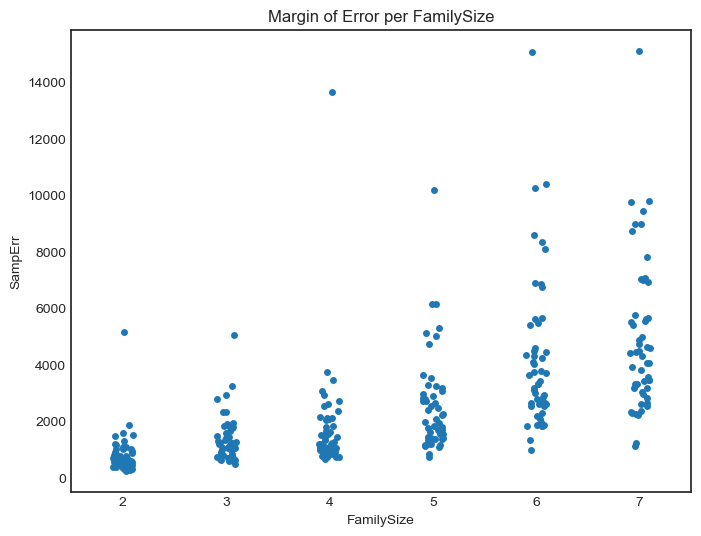

In [34]:
# There are fewer large-sized families than small-sized families, making the medians for income
# for the former group noisier. We can modulate the noise parameter with the margin of error.
plt.figure(figsize=(8, 6))
sns.stripplot(x="FamilySize", y="SampErr", data=df_income)
plt.title("Margin of Error per FamilySize");

In [38]:
with pm.Model(coords = {'state' : state_codes}) as model4:

    beta0 = pm.Normal("beta0", mu=0, tau=1 / 10**2)
    beta1 = pm.Normal("beta1", mu=0, tau=1 / 10**2)
    beta2 = pm.Normal("beta2", mu=0, tau=1 / 10**2)

    sigma0 = pm.Uniform("sigma0", 10**-3, 10**3)
    sigma1 = pm.Uniform("sigma1", 10**-3, 10**3)
    sigma2 = pm.Uniform("sigma2", 10**-3, 10**3)

    beta0_s = pm.Normal("beta0_s", mu=beta0, sigma=sigma0, dims="state")
    beta1_s = pm.Normal("beta1_s", mu=beta1, sigma=sigma1, dims="state")
    beta2_s = pm.Normal("beta2_s", mu=beta2, sigma=sigma2, dims="state")

    mu = beta0_s[state_idx] + beta1_s[state_idx] * z_fs + beta2_s[state_idx] * z_fs**2

    nu = pm.Exponential("nu", 1 / 29.0)
    sigma = pm.Uniform("sigma", 10**-3, 10**3)

    # Modulate the noise parameter with the margin of error.
    w_sigma = z_error * sigma

    likelihood = pm.StudentT(
        "likelihood", nu=nu, mu=mu, sigma=w_sigma, observed=z_income
    )
    

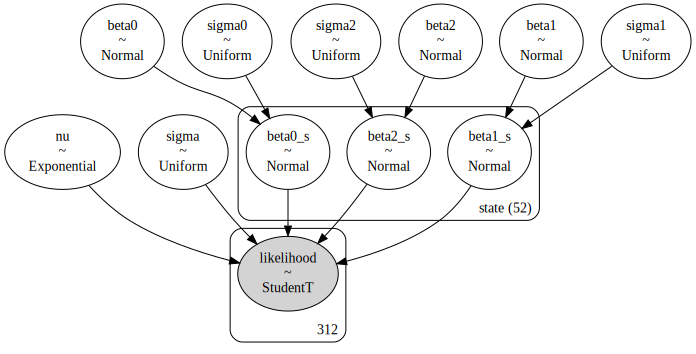

In [39]:
pm.model_to_graphviz(model4)

In [40]:
with model4:
    idata4 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, sigma0, sigma1, sigma2, beta0_s, beta1_s, beta2_s, nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 173 seconds.


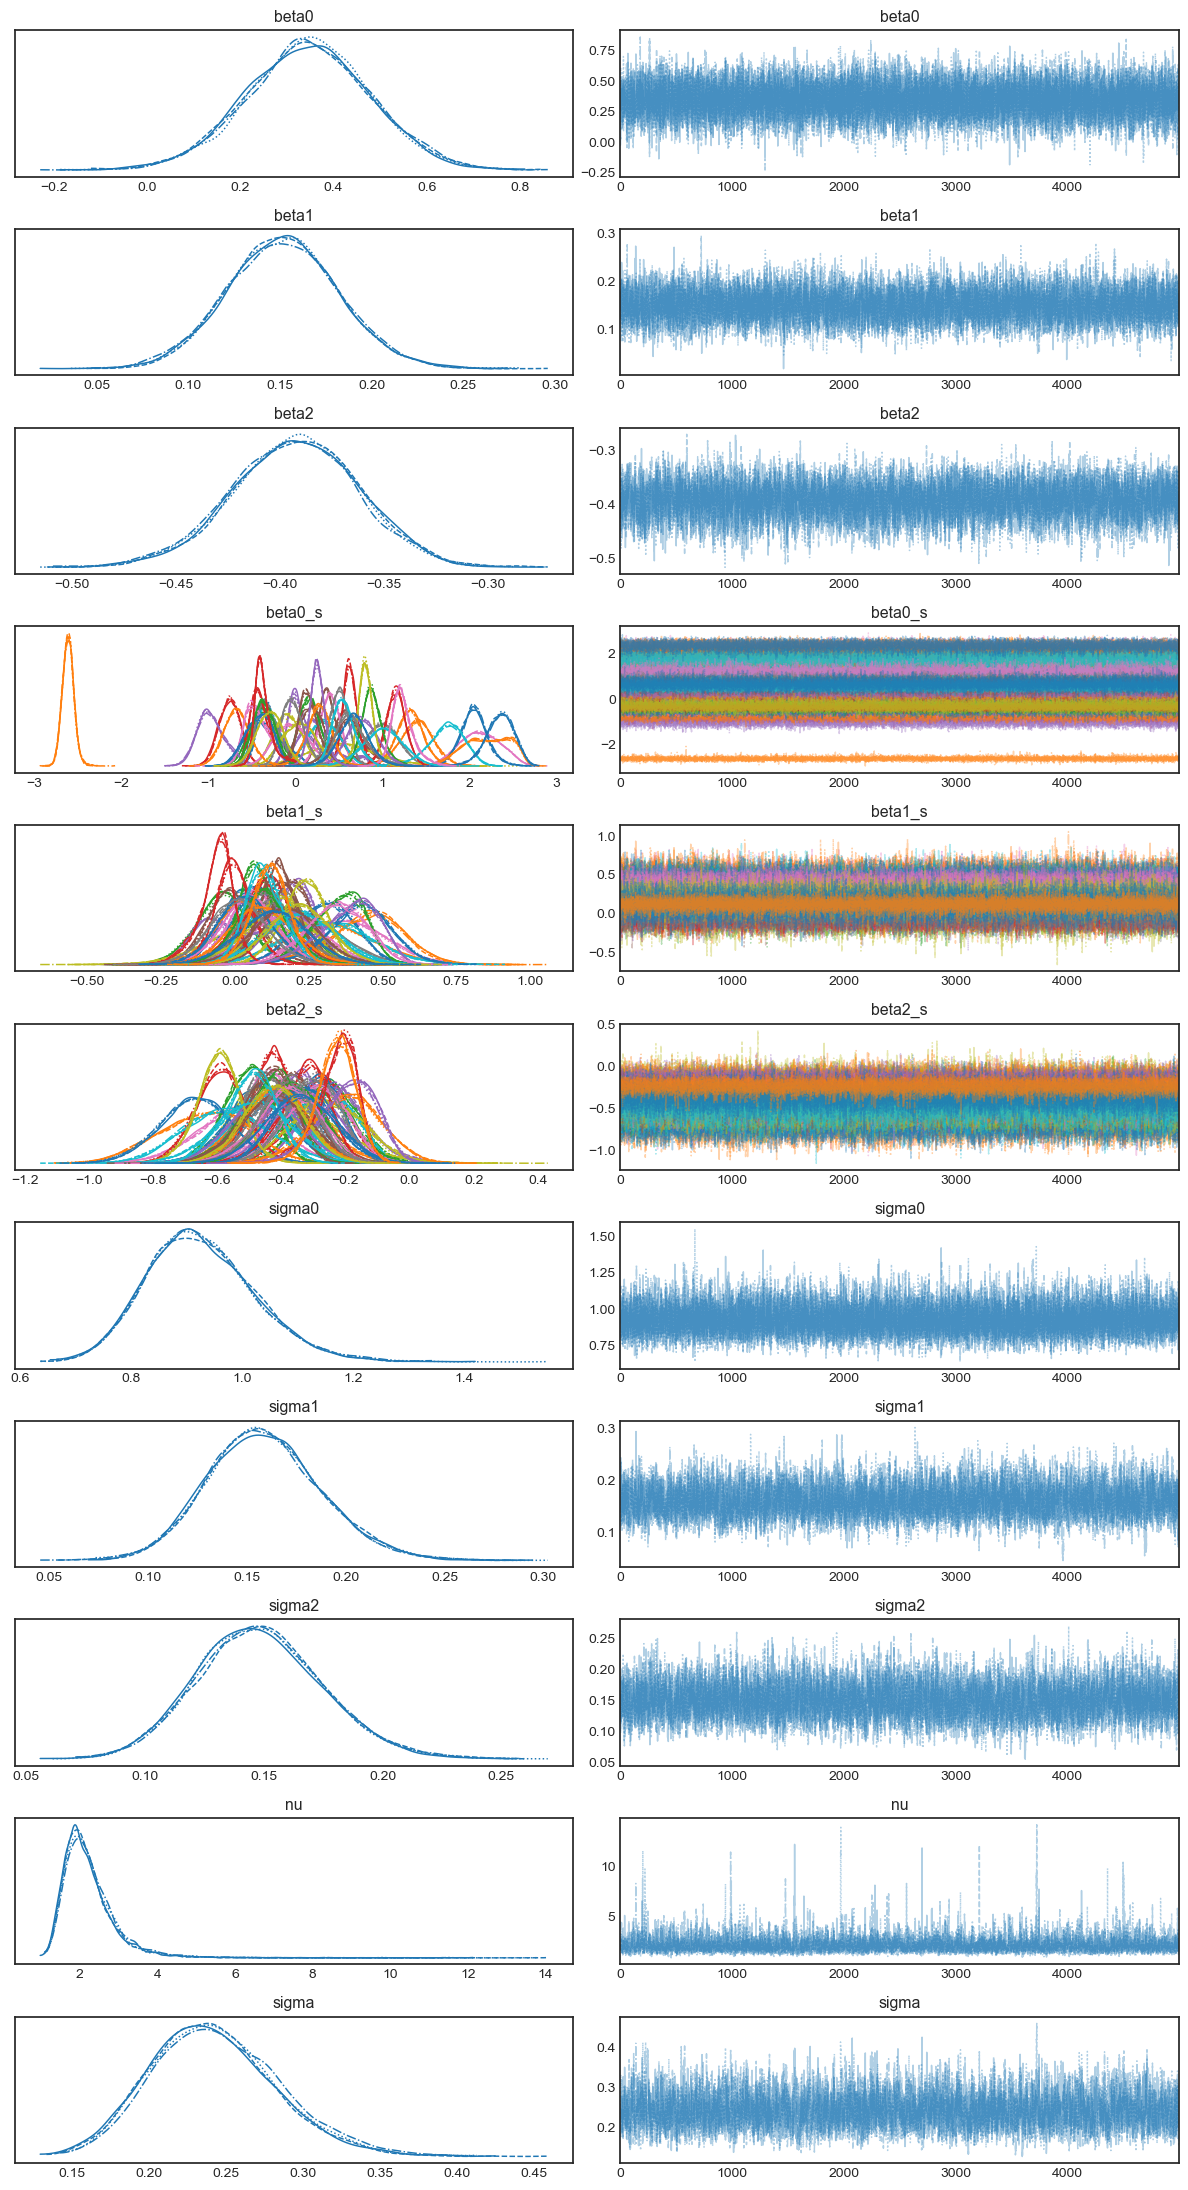

In [41]:
az.plot_trace(idata4)
plt.tight_layout();

In [42]:
az.summary(idata4)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0             0.347  0.133   0.097    0.597      0.001    0.001   20725.0   
beta1             0.152  0.030   0.094    0.208      0.000    0.000    7846.0   
beta2            -0.393  0.031  -0.450   -0.335      0.000    0.000    4617.0   
beta0_s[Alabama] -0.382  0.174  -0.684   -0.058      0.002    0.001   11639.0   
beta0_s[Alaska]   1.399  0.195   1.041    1.780      0.002    0.001   16512.0   
...                 ...    ...     ...      ...        ...      ...       ...   
sigma0            0.927  0.098   0.748    1.110      0.001    0.001   19142.0   
sigma1            0.159  0.029   0.107    0.216      0.000    0.000    4535.0   
sigma2            0.149  0.027   0.098    0.198      0.000    0.000    4779.0   
nu                2.229  0.728   1.247    3.429      0.012    0.008    3683.0   
sigma             0.242  0.041   0.169    0.322      0.001    0.001    2797.0   

                  ess_tail  r_hat  
beta0              12844.0    1.0  
beta1              12058.0    1.0  
beta2               8628.0    1.0  
beta0_s[Alabama]   14613.0    1.0  
beta0_s[Alaska]    13723.0    1.0  
...                    ...    ...  
sigma0             13846.0    1.0  
sigma1              5464.0    1.0  
sigma2              7066.0    1.0  
nu                  6807.0    1.0  
sigma               4903.0    1.0  

[164 rows x 9 columns]

C:\Users\bacos1\AppData\Local\Temp\ipykernel_19496\1186446613.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_income.groupby("State").apply(
C:\Users\bacos1\AppData\Local\Temp\ipykernel_19496\1186446613.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_income.groupby("State").apply(


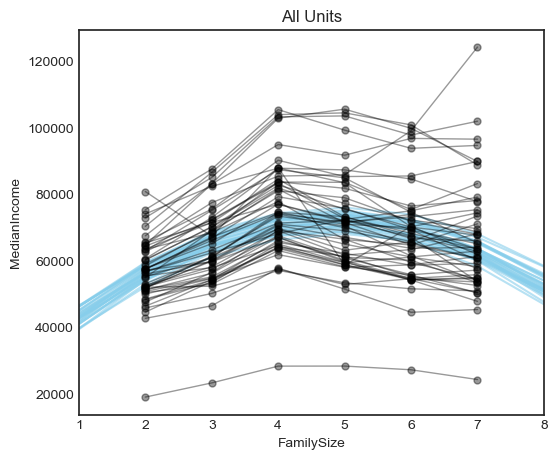

In [43]:
plt.figure(figsize=(6, 5))
ax = plt.gca()

df_income.groupby("State").apply(
    lambda group: ax.plot(
        group.FamilySize, group.MedianIncome, "k-o", lw=1, markersize=5, alpha=0.4
    )
)
ax.set(xlabel="FamilySize", ylabel="MedianIncome", xlim=(1, 8), title="All Units")

plot_quad_credlines(
    idata4.posterior["beta0"],
    idata4.posterior["beta1"],
    idata4.posterior["beta2"],
    df_income.FamilySize,
    sd_fs,
    sd_income,
    mean_fs,
    mean_income,
    ax,
);